In [1]:
import math
import torch
import hess
import matplotlib.pyplot as plt
from hess.nets import Transformer
import hess.loss_surfaces as loss_surfaces
import numpy as np
import sklearn.datasets as datasets
import hess.utils as utils

In [2]:
def twospirals(n_points, noise=.5, random_state=920):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_points,1)) * 600 * (2*np.pi)/360
    d1x = -1.5*np.cos(n)*n + np.random.randn(n_points,1) * noise
    d1y =  1.5*np.sin(n)*n + np.random.randn(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))),
            np.hstack((np.zeros(n_points),np.ones(n_points))))

In [3]:
np.random.permutation(10)

array([5, 2, 3, 6, 1, 7, 9, 8, 4, 0])

In [4]:
X, Y = twospirals(1500, noise=1.5)
perm = np.random.permutation(3000)
X = X[perm,:]
Y = Y[perm]
num_test = 1000

In [5]:
X.shape

(3000, 2)

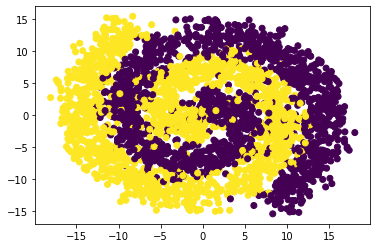

In [6]:
plt.scatter(X[:,0], X[:,1], c=Y)

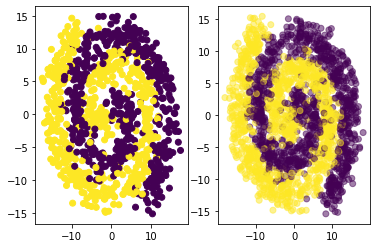

In [7]:
fig, ax = plt.subplots(1, 2)
ax[0].scatter(X[:num_test, 0], X[:num_test, 1], c=Y[:num_test])
ax[1].scatter(X[num_test:,0], X[num_test:, 1], c=Y[num_test:], alpha = 0.5)

In [8]:

train_x = torch.FloatTensor(X[:num_test])
test_x = torch.FloatTensor(X[num_test:])

train_y = torch.FloatTensor(Y[:num_test]).unsqueeze(-1)
test_y = torch.FloatTensor(Y[num_test:]).unsqueeze(-1)

In [9]:
use_cuda = torch.cuda.is_available()
if use_cuda:
    torch.cuda.set_device(0)
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    train_x, train_y = train_x.cuda(), train_y.cuda()
    test_x, test_y = test_x.cuda(), test_y.cuda()

In [10]:
def train_model(model, train_x, train_y):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    loss_func = torch.nn.BCEWithLogitsLoss()

    losses = []

    for step in range(2000):
        optimizer.zero_grad()
        outputs = model(train_x)

        loss=loss_func(outputs, train_y)
        trainL = loss.detach().item()
        if step % 500 is 0:
            print("train loss = ", trainL)
        losses.append(trainL)
        loss.backward()
        optimizer.step()
    
    return losses

In [11]:
def get_model(hidden_size=20, n_hidden=5):
    in_dim = 2
    out_dim = 1
    model = hess.nets.SimpleNet(in_dim, out_dim, n_hidden=n_hidden, hidden_size=hidden_size,
                         activation=torch.nn.ELU(), bias=True)
    
    if use_cuda:
        model=model.cuda()
        
    return model

In [12]:
import hess.utils as utils

def get_hessian(model, train_x, train_y):
    n_par = sum(torch.numel(p) for p in model.parameters())

    hessian = torch.zeros(n_par, n_par)
    for pp in range(n_par):
        base_vec = torch.zeros(n_par).unsqueeze(0)
        base_vec[0, pp] = 1.

        base_vec = utils.unflatten_like(base_vec, model.parameters())
        utils.eval_hess_vec_prod(base_vec, model,
                                criterion=torch.nn.BCEWithLogitsLoss(),
                                inputs=train_x, targets=train_y)
        if pp == 0:
            output = utils.gradtensor_to_tensor(model, include_bn=True)
            hessian = torch.zeros(output.nelement(), output.nelement())
            hessian[:, pp] = output

        hessian[:, pp] = utils.gradtensor_to_tensor(model, include_bn=True).cpu()
        
    return hessian

In [13]:
rep_full_list = []

for rep in range(25):

    eigs_list = []
    losses_list = []
    num_pars = []
    #hessian_list = []
    test_loss_list = []
    
    for i in range(1, 30):
        print('now running', i)

        model = get_model(hidden_size = i)
        n_par = sum(p.numel() for p in model.parameters())

        losses = train_model(model, train_x, train_y)

        hessian = get_hessian(model, train_x, train_y).detach()
        
        with torch.no_grad():
            test_loss = torch.nn.BCEWithLogitsLoss()(model(test_x), test_y)
            print('Test loss is :', test_loss.item())
        
        losses_list.append(losses)
        eigs_list.append(np.linalg.eig(hessian.cpu().numpy())[0])
        num_pars.append(n_par)
        #hessian_list.append(hessian)
        test_loss_list.append(test_loss.item())
        del hessian, model
        
    rep_full_list.append([losses_list, eigs_list, test_loss_list])

now running 1
train loss =  0.6937592625617981
train loss =  0.6435561776161194
train loss =  0.6428884267807007
train loss =  0.6427769660949707
Test loss is : 0.655367910861969
now running 2
train loss =  0.6975830793380737
train loss =  0.5265056490898132
train loss =  0.524895429611206
train loss =  0.5238734483718872
Test loss is : 0.5358317494392395
now running 3
train loss =  0.6941443085670471
train loss =  0.40059858560562134
train loss =  0.3903355896472931
train loss =  0.38396936655044556
Test loss is : 0.4449438154697418
now running 4
train loss =  0.6940065026283264
train loss =  0.3078102171421051
train loss =  0.18465794622898102
train loss =  0.17538107931613922
Test loss is : 0.34159520268440247
now running 5
train loss =  0.7214985489845276
train loss =  0.18289689719676971
train loss =  0.1579279750585556
train loss =  0.14983978867530823
Test loss is : 0.3522525727748871
now running 6
train loss =  0.7466716766357422
train loss =  0.18554678559303284
train loss =  

now running 17
train loss =  0.6939939260482788
train loss =  0.1466084122657776
train loss =  0.12362245470285416
train loss =  0.10166606307029724
Test loss is : 0.9414988160133362
now running 18
train loss =  0.6931765675544739
train loss =  0.14202383160591125
train loss =  0.11588524281978607
train loss =  0.09314446151256561
Test loss is : 0.8506559133529663
now running 19
train loss =  0.6937555074691772
train loss =  0.14527691900730133
train loss =  0.1101289615035057
train loss =  0.09714479744434357
Test loss is : 0.6011539697647095
now running 20
train loss =  0.6954169869422913
train loss =  0.13952399790287018
train loss =  0.08625191450119019
train loss =  0.06609565764665604
Test loss is : 1.076554775238037
now running 21
train loss =  0.6873917579650879
train loss =  0.1439371258020401
train loss =  0.10589579492807388
train loss =  0.09954723715782166
Test loss is : 0.4992743730545044
now running 22
train loss =  0.6985874772071838
train loss =  0.14206340909004211
tr

Test loss is : 0.3059089481830597
now running 4
train loss =  0.7070785164833069
train loss =  0.20318768918514252
train loss =  0.1788531392812729
train loss =  0.17093099653720856
Test loss is : 0.2755851447582245
now running 5
train loss =  0.6976538300514221
train loss =  0.17107988893985748
train loss =  0.19058500230312347
train loss =  0.1502494215965271
Test loss is : 0.3622116446495056
now running 6
train loss =  0.6950108408927917
train loss =  0.20631617307662964
train loss =  0.17619897425174713
train loss =  0.17249231040477753
Test loss is : 0.338685005903244
now running 7
train loss =  0.6966840028762817
train loss =  0.15429401397705078
train loss =  0.1335335075855255
train loss =  0.12103831022977829
Test loss is : 0.8594577312469482
now running 8
train loss =  0.6900792717933655
train loss =  0.1646447479724884
train loss =  0.1468469649553299
train loss =  0.12439226359128952
Test loss is : 0.6093261241912842
now running 9
train loss =  0.6917833685874939
train loss

Test loss is : 1.6051150560379028
now running 20
train loss =  0.6966608166694641
train loss =  0.12914685904979706
train loss =  0.09595273435115814
train loss =  0.0851079598069191
Test loss is : 1.482904314994812
now running 21
train loss =  0.7067362666130066
train loss =  0.12743693590164185
train loss =  0.09267120063304901
train loss =  0.0711761936545372
Test loss is : 0.9698594808578491
now running 22
train loss =  0.6913626790046692
train loss =  0.1258133202791214
train loss =  0.09721045196056366
train loss =  0.06503000855445862
Test loss is : 1.476914882659912
now running 23
train loss =  0.693093478679657
train loss =  0.14024081826210022
train loss =  0.08795610815286636
train loss =  0.10251770913600922
Test loss is : 1.0264461040496826
now running 24
train loss =  0.696928083896637
train loss =  0.12480044364929199
train loss =  0.0773993581533432
train loss =  0.08133216947317123
Test loss is : 1.0279910564422607
now running 25
train loss =  0.694127082824707
train l

Test loss is : 0.27773821353912354
now running 7
train loss =  0.697668194770813
train loss =  0.19024761021137238
train loss =  0.14853467047214508
train loss =  0.1344754993915558
Test loss is : 0.5408583879470825
now running 8
train loss =  0.690115749835968
train loss =  0.1634439378976822
train loss =  0.15239548683166504
train loss =  0.13456548750400543
Test loss is : 0.5081578493118286
now running 9
train loss =  0.6938393712043762
train loss =  0.1656971126794815
train loss =  0.14479456841945648
train loss =  0.11844491213560104
Test loss is : 0.8093066811561584
now running 10
train loss =  0.6931079626083374
train loss =  0.15743999183177948
train loss =  0.13330069184303284
train loss =  0.11982869356870651
Test loss is : 0.8477852940559387
now running 11
train loss =  0.7072243690490723
train loss =  0.14937864243984222
train loss =  0.13391879200935364
train loss =  0.13498887419700623
Test loss is : 0.5775781869888306
now running 12
train loss =  0.6974319815635681
train

train loss =  0.051541004329919815
Test loss is : 1.147841453552246
now running 23
train loss =  0.6942760348320007
train loss =  0.13240553438663483
train loss =  0.0986516922712326
train loss =  0.07727982848882675
Test loss is : 1.0691255331039429
now running 24
train loss =  0.7021135091781616
train loss =  0.144680917263031
train loss =  0.11410393565893173
train loss =  0.10684381425380707
Test loss is : 0.8583950996398926
now running 25
train loss =  0.6951736211776733
train loss =  0.22723618149757385
train loss =  0.08615979552268982
train loss =  0.07677655667066574
Test loss is : 1.1476672887802124
now running 26
train loss =  0.6923639178276062
train loss =  0.12502029538154602
train loss =  0.11862672865390778
train loss =  0.054557107388973236
Test loss is : 1.3978533744812012
now running 27
train loss =  0.6997539401054382
train loss =  0.14097976684570312
train loss =  0.08146915584802628
train loss =  0.07144816964864731
Test loss is : 1.2913620471954346
now running 28

train loss =  0.1275157630443573
Test loss is : 0.7531329989433289
now running 10
train loss =  0.6885058879852295
train loss =  0.15257859230041504
train loss =  0.14174602925777435
train loss =  0.12057385593652725
Test loss is : 0.7881717681884766
now running 11
train loss =  0.6923121213912964
train loss =  0.15343672037124634
train loss =  0.28135260939598083
train loss =  0.14749161899089813
Test loss is : 0.6874972581863403
now running 12
train loss =  0.6934509873390198
train loss =  0.1559908241033554
train loss =  0.13637381792068481
train loss =  0.13956865668296814
Test loss is : 0.8645508289337158
now running 13
train loss =  0.7098631858825684
train loss =  0.36187171936035156
train loss =  0.1502676159143448
train loss =  0.09760162979364395
Test loss is : 0.8949492573738098
now running 14
train loss =  0.694840133190155
train loss =  0.12762701511383057
train loss =  0.09299986809492111
train loss =  0.070364810526371
Test loss is : 1.2127517461776733
now running 15
tra

train loss =  0.087428018450737
Test loss is : 1.1056634187698364
now running 26
train loss =  0.6947809457778931
train loss =  0.13207104802131653
train loss =  0.06937798112630844
train loss =  0.07672011107206345
Test loss is : 0.8576852083206177
now running 27
train loss =  0.6872934699058533
train loss =  0.1294298768043518
train loss =  0.10193535685539246
train loss =  0.09296353906393051
Test loss is : 0.7940892577171326
now running 28
train loss =  0.6905781030654907
train loss =  0.1208132803440094
train loss =  0.07300708442926407
train loss =  0.07967802882194519
Test loss is : 1.6498013734817505
now running 29
train loss =  0.6965471506118774
train loss =  0.1437523514032364
train loss =  0.1334020346403122
train loss =  0.06818826496601105
Test loss is : 1.492669939994812
now running 1
train loss =  0.7558678388595581
train loss =  0.6086487174034119
train loss =  0.5986571311950684
train loss =  0.5971180200576782
Test loss is : 0.61949223279953
now running 2
train loss 

train loss =  0.11211825907230377
Test loss is : 0.9326624870300293
now running 13
train loss =  0.7095813155174255
train loss =  0.1537082940340042
train loss =  0.15938490629196167
train loss =  0.1986009031534195
Test loss is : 0.6657707691192627
now running 14
train loss =  0.7109479308128357
train loss =  0.1888607293367386
train loss =  0.1116274744272232
train loss =  0.08836782723665237
Test loss is : 0.8936225771903992
now running 15
train loss =  0.7060567140579224
train loss =  0.1435876339673996
train loss =  0.1495095193386078
train loss =  0.11405551433563232
Test loss is : 0.8049498200416565
now running 16
train loss =  0.7037176489830017
train loss =  0.15613187849521637
train loss =  0.1674933284521103
train loss =  0.11381635069847107
Test loss is : 0.8084155321121216
now running 17
train loss =  0.6994852423667908
train loss =  0.15007708966732025
train loss =  0.12339461594820023
train loss =  0.07685761153697968
Test loss is : 1.2866421937942505
now running 18
trai

train loss =  0.09432084113359451
Test loss is : 0.9951809644699097
now running 29
train loss =  0.6922646760940552
train loss =  0.13213886320590973
train loss =  0.09959603101015091
train loss =  0.05392485857009888
Test loss is : 1.2809810638427734
now running 1
train loss =  0.7938827276229858
train loss =  0.641065776348114
train loss =  0.640520453453064
train loss =  0.640388548374176
Test loss is : 0.6531918048858643
now running 2
train loss =  0.7157630324363708
train loss =  0.5346407890319824
train loss =  0.5271657109260559
train loss =  0.5201902985572815
Test loss is : 0.5387038588523865
now running 3
train loss =  0.7116187810897827
train loss =  0.21162693202495575
train loss =  0.19372330605983734
train loss =  0.19125138223171234
Test loss is : 0.2714182436466217
now running 4
train loss =  0.7478477954864502
train loss =  0.19474104046821594
train loss =  0.18329685926437378
train loss =  0.17703382670879364
Test loss is : 0.2590126395225525
now running 5
train loss 

train loss =  0.20312844216823578
Test loss is : 0.719211220741272
now running 16
train loss =  0.6920392513275146
train loss =  0.16900677978992462
train loss =  0.10976250469684601
train loss =  0.10641258955001831
Test loss is : 1.155631184577942
now running 17
train loss =  0.6995164155960083
train loss =  0.13822370767593384
train loss =  0.11968063563108444
train loss =  0.09313871711492538
Test loss is : 1.1507718563079834
now running 18
train loss =  0.7261339426040649
train loss =  0.13315622508525848
train loss =  0.09384749829769135
train loss =  0.0691412091255188
Test loss is : 1.2264317274093628
now running 19
train loss =  0.6861094832420349
train loss =  0.16297407448291779
train loss =  0.12420231848955154
train loss =  0.07573848217725754
Test loss is : 0.761726438999176
now running 20
train loss =  0.695395290851593
train loss =  0.127235546708107
train loss =  0.09432301670312881
train loss =  0.1057717576622963
Test loss is : 1.1930701732635498
now running 21
train

train loss =  0.48448464274406433
Test loss is : 0.5103974938392639
now running 3
train loss =  0.7061541080474854
train loss =  0.22520668804645538
train loss =  0.20990754663944244
train loss =  0.20286165177822113
Test loss is : 0.2624094486236572
now running 4
train loss =  0.6978445649147034
train loss =  0.18564008176326752
train loss =  0.17103467881679535
train loss =  0.17077018320560455
Test loss is : 0.3018878400325775
now running 5
train loss =  0.6888883709907532
train loss =  0.17205096781253815
train loss =  0.15433457493782043
train loss =  0.14628060162067413
Test loss is : 0.5911953449249268
now running 6
train loss =  0.7190176248550415
train loss =  0.165204256772995
train loss =  0.15192432701587677
train loss =  0.1356469988822937
Test loss is : 0.4252387583255768
now running 7
train loss =  0.6984554529190063
train loss =  0.16593310236930847
train loss =  0.13400034606456757
train loss =  0.1254284828901291
Test loss is : 0.5597086548805237
now running 8
train l

train loss =  0.08498382568359375
Test loss is : 1.0213236808776855
now running 19
train loss =  0.6980839967727661
train loss =  0.13462935388088226
train loss =  0.190683051943779
train loss =  0.06306447833776474
Test loss is : 1.5314624309539795
now running 20
train loss =  0.7006713151931763
train loss =  0.13680915534496307
train loss =  0.08307133615016937
train loss =  0.06004612147808075
Test loss is : 0.9393802881240845
now running 21
train loss =  0.6857885718345642
train loss =  0.15189987421035767
train loss =  0.09783165156841278
train loss =  0.08196719735860825
Test loss is : 1.5561407804489136
now running 22
train loss =  0.6986212134361267
train loss =  0.13864649832248688
train loss =  0.07740259170532227
train loss =  0.06827164441347122
Test loss is : 1.548108458518982
now running 23
train loss =  0.7010193467140198
train loss =  0.12990979850292206
train loss =  0.09506906569004059
train loss =  0.08323553949594498
Test loss is : 1.132150650024414
now running 24
t

train loss =  0.1597534865140915
Test loss is : 0.3367694318294525
now running 6
train loss =  0.7045711874961853
train loss =  0.16238407790660858
train loss =  0.14329318702220917
train loss =  0.13194288313388824
Test loss is : 0.7337802052497864
now running 7
train loss =  0.693890392780304
train loss =  0.13874417543411255
train loss =  0.14312192797660828
train loss =  0.10388428717851639
Test loss is : 1.746912956237793
now running 8
train loss =  0.7199922204017639
train loss =  0.15230818092823029
train loss =  0.132531076669693
train loss =  0.13086187839508057
Test loss is : 1.0363951921463013
now running 9
train loss =  0.6970222592353821
train loss =  0.1519325226545334
train loss =  0.13535252213478088
train loss =  0.11861243844032288
Test loss is : 0.5562261939048767
now running 10
train loss =  0.7150452136993408
train loss =  0.32707351446151733
train loss =  0.12546499073505402
train loss =  0.1106228306889534
Test loss is : 0.8236580491065979
now running 11
train lo

train loss =  0.0751676931977272
Test loss is : 1.2590440511703491
now running 22
train loss =  0.6945956349372864
train loss =  0.13248848915100098
train loss =  0.10366950184106827
train loss =  0.07670924812555313
Test loss is : 0.674094557762146
now running 23
train loss =  0.7078148722648621
train loss =  0.1293465495109558
train loss =  0.0946219339966774
train loss =  0.09636887162923813
Test loss is : 1.1995482444763184
now running 24
train loss =  0.694194495677948
train loss =  0.12955349683761597
train loss =  0.0883312001824379
train loss =  0.14371849596500397
Test loss is : 1.535693645477295
now running 25
train loss =  0.6962363123893738
train loss =  0.123347207903862
train loss =  0.08150463551282883
train loss =  0.09517870098352432
Test loss is : 0.8682201504707336
now running 26
train loss =  0.7027046084403992
train loss =  0.18860232830047607
train loss =  0.0825137048959732
train loss =  0.06261997669935226
Test loss is : 1.778478980064392
now running 27
train lo

train loss =  0.12854520976543427
Test loss is : 0.5104140043258667
now running 9
train loss =  0.6920440196990967
train loss =  0.16191190481185913
train loss =  0.13910700380802155
train loss =  0.13024111092090607
Test loss is : 0.5615918040275574
now running 10
train loss =  0.699754536151886
train loss =  0.15531110763549805
train loss =  0.15523597598075867
train loss =  0.13652829825878143
Test loss is : 0.5794047117233276
now running 11
train loss =  0.7036734223365784
train loss =  0.18239814043045044
train loss =  0.15494243800640106
train loss =  0.12339711934328079
Test loss is : 0.5845459699630737
now running 12
train loss =  0.6865825057029724
train loss =  0.1420385241508484
train loss =  0.11264724284410477
train loss =  0.07898351550102234
Test loss is : 1.2595854997634888
now running 13
train loss =  0.6924858689308167
train loss =  0.1617966890335083
train loss =  0.1269969940185547
train loss =  0.10583274066448212
Test loss is : 0.754231870174408
now running 14
tra

train loss =  0.13548102974891663
train loss =  0.05588483810424805
Test loss is : 1.6372289657592773
now running 25
train loss =  0.6964414119720459
train loss =  0.13029398024082184
train loss =  0.10734160244464874
train loss =  0.07944676280021667
Test loss is : 0.9315458536148071
now running 26
train loss =  0.6917953491210938
train loss =  0.18975752592086792
train loss =  0.0812392458319664
train loss =  0.06794051080942154
Test loss is : 1.5959539413452148
now running 27
train loss =  0.7102243304252625
train loss =  0.11555853486061096
train loss =  0.11277006566524506
train loss =  0.10650111734867096
Test loss is : 1.5026072263717651
now running 28
train loss =  0.70616215467453
train loss =  0.1457594931125641
train loss =  0.07606136798858643
train loss =  0.07216037064790726
Test loss is : 1.2131855487823486
now running 29
train loss =  0.694273054599762
train loss =  0.1122656762599945
train loss =  0.07588866353034973
train loss =  0.0799742341041565
Test loss is : 1.94

In [14]:
def eff_dim(x, s = 0.1):
    return np.sum(x / (x + s))



In [15]:
ed_list = []
fl_list = []
for losses_list, eigs_list, _ in rep_full_list:
    eff_dim_arr = np.array([eff_dim(ee, s = 50.) for ee in eigs_list])
    final_loss = [l[-1] for l in losses_list]
    
    ed_list.append(eff_dim_arr)
    fl_list.append(final_loss)
    
ed_list = np.array(ed_list)
fl_list = np.array(fl_list)
tl_list = np.array([ee[-1] for ee in rep_full_list])

/home/wesley/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/wesley/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:5285: ComplexWarning: Casting complex values to real discards the imaginary part
  X[0] = start
/home/wesley/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:5286: ComplexWarning: Casting complex values to real discards the imaginary part
  X[N + 1] = end
/home/wesley/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:5289: ComplexWarning: Casting complex values to real discards the imaginary part
  X[1:N + 1, 1] = y1slice
/home/wesley/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:5291: ComplexWarning: Casting complex values to real discards the imaginary part
  X[N + 2:, 1] = y2slice[::-1]


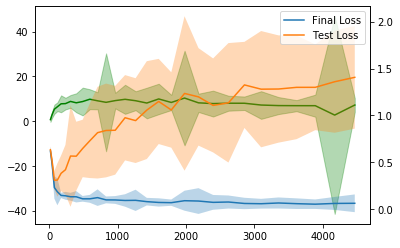

In [16]:
fig, ax = plt.subplots()

ax.plot(num_pars, ed_list.mean(0), label = 'Effective Dim', color = 'green')
ax.fill_between(num_pars, ed_list.mean(0) - 2 * ed_list.std(0), ed_list.mean(0) + 2*ed_list.std(0), alpha = 0.3,
               color='green')

ax2 = ax.twinx()
ax2.plot(num_pars, fl_list.mean(0), label = 'Final Loss')
ax2.fill_between(num_pars, fl_list.mean(0) - 2 * fl_list.std(0), fl_list.mean(0) + 2*fl_list.std(0), alpha = 0.3)

ax2.plot(num_pars, tl_list.mean(0), label = 'Test Loss')
ax2.fill_between(num_pars, tl_list.mean(0) - 2 * tl_list.std(0), tl_list.mean(0) + 2*tl_list.std(0), alpha = 0.3)

ax2.legend()
#plt.semilogy()
#plt.ylim(0, 3)
#plt.vlines(train_x.shape[0], 0, 3)

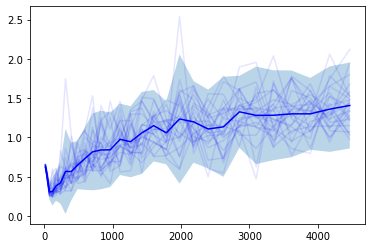

In [17]:
plt.plot(num_pars, tl_list.mean(0), label = 'Test Loss', color= 'blue')
plt.fill_between(num_pars, tl_list.mean(0) - 2 * tl_list.std(0), tl_list.mean(0) + 2*tl_list.std(0), alpha = 0.3)

plt.plot(num_pars, tl_list.T, color = 'blue', alpha = 0.1)

(0, 16)

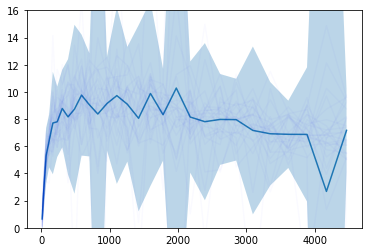

In [21]:
plt.plot(num_pars, ed_list.mean(0), label = 'Effective Dim')
plt.fill_between(num_pars, ed_list.mean(0) - 2 * ed_list.std(0), ed_list.mean(0) + 2*ed_list.std(0), alpha = 0.3)

plt.plot(num_pars, ed_list.T, color = 'blue', alpha = 0.02)
plt.ylim((0, 16))

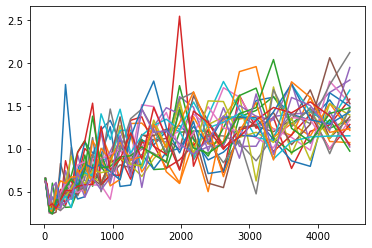

In [19]:
plt.plot(num_pars, tl_list.T)

In [22]:
import pickle

In [27]:
with open('../saved-experiments/two_spirals_descent.pkl', 'wb') as handle:
    pickle.dump([rep_full_list, num_pars], handle, pickle.HIGHEST_PROTOCOL)

In [26]:
rep_full_list

KeyboardInterrupt: 